# DeltaColorClip_IQR MAG_AUTO

Based on S. Allam's MagClip_Pandas.py code...

Created:  2020.10.01 --updated Oct21,2020 --last update Oct27,2020, Nov11,2020

## 1. Initial Setup...

In [1]:
import numpy as np
import pandas as pd
import glob
import math
import os

import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
cd /data/des40.a/data/dtucker/Y6A1_abscal/SynthMags/PETModels/PETModelsCombined/Y6A2CoaddSummary_MAG_AUTO

/data/des40.a/data/dtucker/Y6A1_abscal/SynthMags/PETModels/PETModelsCombined/Y6A2CoaddSummary_MAG_AUTO


In [3]:
%ls -FlthrG ../../../CalSpec/test/

total 1.9G
-rw-rw-r-- 1 dtucker 4.1K Mar 21  2019 qaPlots.bash
-rw-rw-r-- 1 dtucker  647 Jul 11  2019 synthColorList_gaia_match.bash
-rw-rw-r-- 1 dtucker  791 Jul 17  2019 y4a1_fgcm_stds_synthColorList_gaia_match.bash
-rwxrwxr-x 1 dtucker 1.2K Jul 17  2019 getEBV_new.py*
-rw-rw-r-- 1 dtucker 9.5K Jul 17  2019 qaPlots.y4a1.bash
-rwxrwxr-x 1 dtucker 4.5K Jul 25  2019 uniqHealpixList.py*
-rw-rw-r-- 1 dtucker  922 Oct 22  2019 y6a1_fgcm_stds_synthColorList_gaia_match.bash
-rw-rw-r-- 1 dtucker 9.5K Oct 22  2019 qaPlots.y6a1.bash~
-rw-rw-r-- 1 dtucker 8.1K Nov 11  2019 calc_abmag.non_des.bash
-rw-rw-r-- 1 dtucker 4.1K Dec 12  2019 calc_abmag.bash~
-rw-rw-r-- 1 dtucker   54 Dec 12  2019 109vir_mod_001.mag.csv
-rw-rw-r-- 1 dtucker   54 Dec 12  2019 109vir_stis_001.mag.csv
-rw-rw-r-- 1 dtucker   54 Dec 12  2019 10lac_mod_002.mag.csv
-rw-rw-r-- 1 dtucker   54 Dec 12  2019 10lac_stis_004.mag.csv
-rw-rw-r-- 1 dtucker   54 Dec 12  2019 16cygb_mod_001.mag.csv
-rw-rw-r-- 1 dtucker   54 Dec 12  2019 1

## 2. Input Files...

In [4]:
# Input files for FGCM mag_psf solution...
inputFile='../ueberMasterList.1D_3D_MR.y6a2Coadd.csv'
inputFile_calspec = '../../../CalSpec/v2020-04-27/y6a2CoaddSummary_match_best_36arcsec.combined.csv'
inputFile_narayan = '../../../Narayan_G_2019_WDs/gnarayan-WDdata-b2daf1e/y6a2CoaddSummary_match_best_36arcsec.combined.des.csv'

#inputFile_calspec = '../../../CalSpec/test/Y6A1_FGCM_V3_3_1_PSF_ALL_STARS.full_match.new.mag_color.csv'
#inputFile_narayan = '../../../Narayan_G_2019_WDs/gnarayan-WDdata-b2daf1e/Y6A1_FGCM_V3_3_1_PSF_ALL_STARS.full_match.new.mag_color.des.csv'


## 3.  Plotting Functions...

### Histogram function...

In [5]:
def histPlotCompare3(data_df, data_df_clean, data_df_cleaner, column_x, title, xlabel, xlo, xhi, nbins):
    plt.hist( x=data_df[column_x], bins=nbins, range=(xlo,xhi), color='red', label='pre-cut')
    plt.hist( x=data_df_clean[column_x], bins=nbins, range=(xlo,xhi), color='yellow', label='stat. outlier' )
    plt.hist( x=data_df_cleaner[column_x], bins=nbins, range=(xlo,xhi), color='green', label='good' )
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number')
    return 0

### Main XY Plot Function...

In [6]:
def xyPlotCompare3(data_df, data_df_clean, data_df_cleaner, 
                   column_x, column_y, column_xerr, column_yerr, 
                   title, xlabel, ylabel, xlo, xhi, ylo, yhi, y_refvalue=0.00):
    plt.errorbar(data_df[column_x],data_df[column_y], \
                 xerr=data_df[column_xerr], yerr=data_df[column_yerr], \
                 fmt='.',color='red', ecolor='lightgray', elinewidth=3, capsize=0, label='pre-cut' )
    plt.errorbar(data_df_clean[column_x],data_df_clean[column_y], \
                 xerr=data_df_clean[column_xerr], yerr=data_df_clean[column_yerr], \
                 fmt='.',color='yellow', ecolor='yellow', elinewidth=3, capsize=0, label='stat. outlier' )
    plt.errorbar(data_df_cleaner[column_x],data_df_cleaner[column_y], \
                 xerr=data_df_cleaner[column_xerr], yerr=data_df_cleaner[column_yerr], \
                 fmt='.',color='green', ecolor='green', elinewidth=3, capsize=0, label='good' )
    plt.plot([xlo,xhi], [y_refvalue,y_refvalue], linestyle='dashed', label='mean')
    plt.xlim([xlo, xhi])
    plt.ylim([ylo, yhi])
    plt.grid(True)
    #plt.legend()
    plt.legend(loc='lower right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return 0

### HST CalSpec XY Overplot Function...

In [7]:
def xyPlotOverplotCalSpec(calspec_df, column_x, column_y, column_xerr, column_yerr, ylo, yhi):
    
    plt.errorbar(calspec_df[column_x],calspec_df[column_y], \
                 xerr=calspec_df[column_xerr], yerr=calspec_df[column_yerr], \
                 fmt='.', color='blueviolet', ecolor='blueviolet', elinewidth=3, capsize=0, \
                 ms=15, label='HST CalSpec' )

    txt_array = calspec_df.objShortName.values
    x_array = calspec_df[column_x].values
    y_array = calspec_df[column_y].values
    #y2_array = np.full(len(txt_array), -0.07)
    
    for i, txt in enumerate(txt_array):
        
        yy = ylo + 0.20*(yhi-ylo)
        if txt == 'feige110':
            yy = yy + 0.05*(yhi-ylo)
    
        ax.annotate(txt, \
                    xy=(x_array[i], yy), \
                    color='blueviolet', ha='center')

        #ax.annotate(txt, \
        #            xy=(x_array[i], y_array[i]), \
        #            xytext=(x_array[i], y2_array[i]), \
        #            color='blueviolet', ha='center', \
        #            arrowprops=dict(arrowstyle="->", facecolor='blueviolet'))

       
        
    plt.legend(loc='lower right')

    return 0

### Narayan et al. (2019) DA White Dwarf XY Overplot Function...

In [8]:
def xyPlotOverplotNarayan(narayan_df, column_x, column_y, column_xerr, column_yerr, ylo, yhi):
    
    plt.errorbar(narayan_df[column_x],narayan_df[column_y], \
                 xerr=narayan_df[column_xerr], yerr=narayan_df[column_yerr], \
                 fmt='.', color='deepskyblue', ecolor='deepskyblue', elinewidth=3, capsize=0, \
                 ms=15, label='Narayan et al. (2019)' )

    txt_array = narayan_df.objShortName.values
    x_array = narayan_df[column_x].values
    y_array = narayan_df[column_y].values
    y2_array = np.full(len(txt_array), -0.13)
    
    for i, txt in enumerate(txt_array):

        #yy = -0.12 + 0.02*(i%2)
        yy = ylo + 0.10*(yhi-ylo)
        yy = yy + 0.05*(yhi-ylo)*(i%2)

        ax.annotate(txt, \
                    xy=(x_array[i], yy), \
                    color='deepskyblue', ha='center')

        #ax.annotate(txt, \
        #            xy=(x_array[i], y_array[i]), \
        #            xytext=(x_array[i], y2_array[i]), \
        #            color='deepskyblue', ha='center', \
        #            arrowprops=dict(arrowstyle="->", facecolor='deepskyblue'))

       
        
    plt.legend(loc='lower right')

    return 0

## 4. Read in  main input file...

In [9]:
data_df = pd.read_csv(inputFile)
data_df.head(5)

,set_obsRun_objShortName,model_set,model_dimen,preferred_model_dimen,dirname,filename,Teff,errT,logg,errg,...,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,sep_arcsec_coadd,SFD98_EBV_max,R_sun_thick,R_sun_thin
0,1_???_SSSJ013843-8325,1,1,1,NaN,spSpec-SSSJ013843-8325.ms.fits,32387.0,1935.0,6.056,0.401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.144093,NaN,NaN
1,1_???_SSSJ033904-4037,1,1,1,NaN,spSpec-SSSJ033904-4037.ms.fits,29043.0,1563.0,6.536,0.289,...,0.000044,-0.000103,0.0,0.0,7.0,2.841749e+15,4.689819,0.011286,NaN,NaN
2,1_???_SSSJ040532-5055,1,1,1,NaN,spSpec-SSSJ040532-5055.ms.fits,18798.0,1634.0,7.692,0.283,...,0.001515,-0.000482,0.0,0.0,10.0,2.842110e+15,15.951593,0.013446,0.016107,0.015668
3,1_???_SSSJ041250-4510,1,1,0,NaN,spSpec-SSSJ041250-4510.ms.fits,12615.0,601.0,8.033,0.167,...,0.000040,-0.000528,0.0,0.0,8.0,2.848821e+15,3.240292,0.022683,0.012616,0.012402
4,1_???_SSSJ043704-5728,1,1,1,NaN,spSpec-SSSJ043704-5728.ms.fits,18519.0,846.0,8.145,0.146,...,0.000065,-0.000147,2.0,0.0,7.0,2.849070e+15,1.749972,0.010637,0.011775,0.011575


### Calculate observed FGCM colors from observed FGCM magnitudes...

In [10]:
data_df['gr_std'] = (data_df['MAG_AUTO_G'] - data_df['MAG_AUTO_R'])
data_df['ri_std'] = (data_df['MAG_AUTO_R'] - data_df['MAG_AUTO_I'])
data_df['iz_std'] = (data_df['MAG_AUTO_I'] - data_df['MAG_AUTO_Z'])
data_df['zY_std'] = (data_df['MAG_AUTO_Z'] - data_df['MAG_AUTO_Y'])

data_df['gi_std'] = (data_df['MAG_AUTO_G'] - data_df['MAG_AUTO_I'])

### Calculate statistical errrors for the observed FGCM colors...

In [12]:
#Assuming 0.1 err for Y-band

#data_df['MAGERR_AUTO_Y']=.1



data_df['gr_std_err']=np.sqrt(data_df['MAGERR_AUTO_G']*data_df['MAGERR_AUTO_G'] + \
                              data_df['MAGERR_AUTO_R']*data_df['MAGERR_AUTO_R'] )
data_df['ri_std_err']=np.sqrt(data_df['MAGERR_AUTO_R']*data_df['MAGERR_AUTO_R'] + \
                              data_df['MAGERR_AUTO_I']*data_df['MAGERR_AUTO_I'] )
data_df['iz_std_err']=np.sqrt(data_df['MAGERR_AUTO_I']*data_df['MAGERR_AUTO_I'] + \
                              data_df['MAGERR_AUTO_Z']*data_df['MAGERR_AUTO_Z'] )
data_df['zY_std_err']=np.sqrt(data_df['MAGERR_AUTO_Z']*data_df['MAGERR_AUTO_Z'] + \
                              data_df['MAGERR_AUTO_Y']*data_df['MAGERR_AUTO_Y'] )

data_df['gi_std_err']=np.sqrt(data_df['MAGERR_AUTO_G']*data_df['MAGERR_AUTO_G'] + \
                              data_df['MAGERR_AUTO_I']*data_df['MAGERR_AUTO_I'] )

### Calculate difference between the observed FGCM colors and the DES AB synthetic colors...

In [13]:
data_df['delta_STD_gr'] = data_df['gr_std'] - data_df['gr_1']
data_df['delta_STD_ri'] = data_df['ri_std'] - data_df['ri_1']
data_df['delta_STD_iz'] = data_df['iz_std'] - data_df['iz_1']
data_df['delta_STD_zY'] = data_df['zY_std'] - data_df['zY_1']

### Calculate DES AB synthetic (g-i) colors for best-fit model ("gi_1") and the +/-errT, +/-errlogg models...

In [14]:
data_df['gi_1'] = ( data_df['gr_1'] + data_df['ri_1'] )
data_df['gi_2'] = ( data_df['gr_2'] + data_df['ri_2'] )
data_df['gi_3'] = ( data_df['gr_3'] + data_df['ri_3'] )
data_df['gi_4'] = ( data_df['gr_4'] + data_df['ri_4'] )
data_df['gi_5'] = ( data_df['gr_5'] + data_df['ri_5'] )

### Calculate the average error in the DES AB synthetic colors based on the +/-errT, +/-errlogg model colors...

In [15]:
data_df['avgerr_gr'] = ( np.abs(data_df['gr_2']-data_df['gr_1']) \
                       + np.abs(data_df['gr_3']-data_df['gr_1']) \
                       + np.abs(data_df['gr_4']-data_df['gr_1']) \
                       + np.abs(data_df['gr_5']-data_df['gr_1']) )/4.0

data_df['avgerr_ri'] = ( np.abs(data_df['ri_2']-data_df['ri_1']) \
                       + np.abs(data_df['ri_3']-data_df['ri_1']) \
                       + np.abs(data_df['ri_4']-data_df['ri_1']) \
                       + np.abs(data_df['ri_5']-data_df['ri_1']) )/4.0

data_df['avgerr_iz'] = ( np.abs(data_df['iz_2']-data_df['iz_1']) \
                       + np.abs(data_df['iz_3']-data_df['iz_1']) \
                       + np.abs(data_df['iz_4']-data_df['iz_1']) \
                       + np.abs(data_df['iz_5']-data_df['iz_1']) )/4.0

data_df['avgerr_zY'] = ( np.abs(data_df['zY_2']-data_df['zY_1']) \
                       + np.abs(data_df['zY_3']-data_df['zY_1']) \
                       + np.abs(data_df['zY_4']-data_df['zY_1']) \
                       + np.abs(data_df['zY_5']-data_df['zY_1']) )/4.0


data_df['avgerr_gi'] = ( np.abs(data_df['gi_2']-data_df['gi_1']) \
                       + np.abs(data_df['gi_3']-data_df['gi_1']) \
                       + np.abs(data_df['gi_4']-data_df['gi_1']) \
                       + np.abs(data_df['gi_5']-data_df['gi_1']) )/4.0

### Estimate the rms statistical error for the (FGCM - Synthetic) colors...

In [16]:
data_df['Err_STD_gr'] = np.sqrt(data_df['MAGERR_AUTO_G']*data_df['MAGERR_AUTO_G'] + \
                                data_df['MAGERR_AUTO_R']*data_df['MAGERR_AUTO_R'] + \
                                data_df['avgerr_gr']*data_df['avgerr_gr'])

data_df['Err_STD_ri'] = np.sqrt(data_df['MAGERR_AUTO_R']*data_df['MAGERR_AUTO_R'] + \
                                data_df['MAGERR_AUTO_I']*data_df['MAGERR_AUTO_I'] + \
                                data_df['avgerr_ri']*data_df['avgerr_ri'])

data_df['Err_STD_iz'] = np.sqrt(data_df['MAGERR_AUTO_I']*data_df['MAGERR_AUTO_I'] + \
                                data_df['MAGERR_AUTO_Z']*data_df['MAGERR_AUTO_Z'] + \
                                data_df['avgerr_iz']*data_df['avgerr_iz'])

data_df['Err_STD_zY'] = np.sqrt(data_df['MAGERR_AUTO_Z']*data_df['MAGERR_AUTO_Z'] + \
                                data_df['MAGERR_AUTO_Y']*data_df['MAGERR_AUTO_Y'] + \
                                data_df['avgerr_zY']*data_df['avgerr_zY'])

## 5. Create masks to remove bad objects...

In [17]:
# DAWDs...
mask1 = data_df.comments_model.isnull()
data_df[mask1].MAG_APER_8_G.size

294

In [18]:
# Good model...
mask2 = (data_df.errT/data_df.Teff < 0.1) & (data_df.errT < 1000.)
data_df[mask2].MAG_APER_8_G.size

356

In [19]:
# Good astrometric matches (based on sanity check with Gaia DR2 colors)...
mask3 = ~( (data_df.MAG_APER_8_G-data_df.MAG_APER_8_R > 0.1) & (data_df.bp_rp < 0.245) )
data_df[mask3].MAG_APER_8_G.size

455

In [20]:
# Gaia DR2 distances less than 300 pc...
mask4 = data_df.r_est < 300.
data_df[mask4].MAG_APER_8_G.size

313

In [21]:
# Preferred model:  1D or 3D?...
mask5 = (data_df.preferred_model_dimen == 1)
data_df[mask5].MAG_APER_8_G.size

430

In [22]:
# Combined masks...
mask = mask1 & mask2 & mask3 & mask4 & mask5
data_df[mask].MAG_APER_8_G.size

213

In [23]:
data_df_clean = data_df[mask].copy()

In [24]:
data_df_clean

,set_obsRun_objShortName,model_set,model_dimen,preferred_model_dimen,dirname,filename,Teff,errT,logg,errg,...,gi_5,avgerr_gr,avgerr_ri,avgerr_iz,avgerr_zY,avgerr_gi,Err_STD_gr,Err_STD_ri,Err_STD_iz,Err_STD_zY
4,1_???_SSSJ043704-5728,1,1,1,NaN,spSpec-SSSJ043704-5728.ms.fits,18519.0,846.0,8.145,0.146,...,-0.6844,0.012975,0.006375,0.003700,0.002125,0.019350,0.012978,0.006388,0.003786,0.003664
5,1_???_SSSJ063529-5920,1,1,1,NaN,spSpec-SSSJ063529-5920.ms.fits,16459.0,462.0,8.015,0.086,...,-0.6419,0.009000,0.004425,0.002425,0.001350,0.013425,0.009013,0.004479,0.002808,0.004264
7,1_???_SSSJ105539-2919,1,1,1,NaN,spSpec-SSSJ105539-2919.ms.fits,16891.0,569.0,7.507,0.104,...,-0.6739,0.009350,0.004725,0.003050,0.002000,0.014075,NaN,NaN,NaN,NaN
8,1_???_SSSJ122305-2932,1,1,1,NaN,spSpec-SSSJ122305-2932.ms.fits,18736.0,783.0,8.139,0.134,...,-0.6909,0.011700,0.005775,0.003375,0.001950,0.017475,NaN,NaN,NaN,NaN
9,1_???_SSSJ131117-3025,1,1,1,NaN,spSpec-SSSJ131117-3025.ms.fits,16216.0,716.0,7.987,0.129,...,-0.6298,0.014450,0.007100,0.003875,0.002125,0.021550,NaN,NaN,NaN,NaN
10,1_???_WDC0203-0459,1,1,1,NaN,spSpec-WDC0203-0459_123b.spec.fits,25468.0,266.0,7.842,0.039,...,-0.8268,0.002525,0.001300,0.000850,0.000475,0.003825,0.002569,0.001496,0.001776,0.004826
11,1_???_WDC0204-0459,1,1,1,NaN,spSpec-WDC0204-0459_123b.spec.fits,26717.0,240.0,7.848,0.037,...,-0.8445,0.002175,0.001075,0.000750,0.000425,0.003250,0.002226,0.001306,0.001730,0.004821
15,1_???_WDC0217-0653,1,1,1,NaN,spSpec-WDC0217-0653_123b.spec.fits,14827.0,473.0,8.079,0.067,...,-0.5772,0.012800,0.006525,0.003475,0.001475,0.019325,0.012862,0.006851,0.005639,0.015203
25,1_???_WDC0232-0512,1,1,1,NaN,spSpec-WDC0232-0512_123.spec.fits,24297.0,637.0,8.076,0.091,...,-0.7991,0.006525,0.003225,0.002075,0.001200,0.009750,0.006644,0.004025,0.005696,0.019052
26,1_???_WDC0233-0715,1,1,1,NaN,spSpec-WDC0233-0715_123b.spec.fits,23651.0,115.0,7.932,0.016,...,-0.7990,0.001175,0.000600,0.000375,0.000200,0.001775,0.001233,0.000770,0.000723,0.001680


## 6. Read in HST CalSpec input file (for overplotting on DES DA WD results)...

In [25]:
calspec_df = pd.read_csv(inputFile_calspec)
mask1 = calspec_df.NEPOCHS_G.notnull()
mask2 = calspec_df.Separation < 5.0
mask3 = np.abs(calspec_df.MAG_AUTO_I - calspec_df.i) < 0.5
mask = mask1 & mask2 & mask3
calspec_df = calspec_df[mask].copy().reset_index(drop=True)

calspec_df['gr_std'] = (calspec_df['MAG_AUTO_G'] - calspec_df['MAG_AUTO_R'])
calspec_df['ri_std'] = (calspec_df['MAG_AUTO_R'] - calspec_df['MAG_AUTO_I'])
calspec_df['iz_std'] = (calspec_df['MAG_AUTO_I'] - calspec_df['MAG_AUTO_Z'])
calspec_df['zY_std'] = (calspec_df['MAG_AUTO_Z'] - calspec_df['MAG_AUTO_Y'])
calspec_df['gi_std'] = (calspec_df['MAG_AUTO_G'] - calspec_df['MAG_AUTO_I'])

calspec_df['gr_std_err']=np.sqrt(calspec_df['MAGERR_AUTO_G']*calspec_df['MAGERR_AUTO_G'] + \
                                 calspec_df['MAGERR_AUTO_R']*calspec_df['MAGERR_AUTO_R'] )
calspec_df['ri_std_err']=np.sqrt(calspec_df['MAGERR_AUTO_R']*calspec_df['MAGERR_AUTO_R'] + \
                                 calspec_df['MAGERR_AUTO_I']*calspec_df['MAGERR_AUTO_I'] )
calspec_df['iz_std_err']=np.sqrt(calspec_df['MAGERR_AUTO_I']*calspec_df['MAGERR_AUTO_I'] + \
                                 calspec_df['MAGERR_AUTO_Z']*calspec_df['MAGERR_AUTO_Z'] )
calspec_df['zY_std_err']=np.sqrt(calspec_df['MAGERR_AUTO_Z']*calspec_df['MAGERR_AUTO_Z'] + \
                                 calspec_df['MAGERR_AUTO_Y']*calspec_df['MAGERR_AUTO_Y'] )
calspec_df['gi_std_err']=np.sqrt(calspec_df['MAGERR_AUTO_G']*calspec_df['MAGERR_AUTO_G'] + \
                                 calspec_df['MAGERR_AUTO_I']*calspec_df['MAGERR_AUTO_I'] )

calspec_df['gi'] = ( calspec_df['gr'] + calspec_df['ri'] )

calspec_df['avgerr_gr'] = 0.0
calspec_df['avgerr_ri'] = 0.0
calspec_df['avgerr_iz'] = 0.0
calspec_df['avgerr_zY'] = 0.0
calspec_df['avgerr_gi'] = 0.0

calspec_df['delta_STD_gr'] = calspec_df['gr_std'] - calspec_df['gr']
calspec_df['delta_STD_ri'] = calspec_df['ri_std'] - calspec_df['ri']
calspec_df['delta_STD_iz'] = calspec_df['iz_std'] - calspec_df['iz']
calspec_df['delta_STD_zY'] = calspec_df['zY_std'] - calspec_df['zY']

calspec_df['Err_STD_gr'] = np.sqrt(calspec_df['MAGERR_AUTO_G']*calspec_df['MAGERR_AUTO_G'] + \
                                   calspec_df['MAGERR_AUTO_R']*calspec_df['MAGERR_AUTO_R'] + \
                                   calspec_df['avgerr_gr']*calspec_df['avgerr_gr'])

calspec_df['Err_STD_ri'] = np.sqrt(calspec_df['MAGERR_AUTO_R']*calspec_df['MAGERR_AUTO_R'] + \
                                   calspec_df['MAGERR_AUTO_I']*calspec_df['MAGERR_AUTO_I'] + \
                                   calspec_df['avgerr_ri']*calspec_df['avgerr_ri'])

calspec_df['Err_STD_iz'] = np.sqrt(calspec_df['MAGERR_AUTO_I']*calspec_df['MAGERR_AUTO_I'] + \
                                   calspec_df['MAGERR_AUTO_Z']*calspec_df['MAGERR_AUTO_Z'] + \
                                   calspec_df['avgerr_iz']*calspec_df['avgerr_iz'])

calspec_df['Err_STD_zY'] = np.sqrt(calspec_df['MAGERR_AUTO_Z']*calspec_df['MAGERR_AUTO_Z'] + \
                                   calspec_df['MAGERR_AUTO_Y']*calspec_df['MAGERR_AUTO_Y'] + \
                                   calspec_df['avgerr_zY']*calspec_df['avgerr_zY'])

calspec_df
#calspec_df[['objShortName','gr']]

,objShortName,StarName,RAHMS,DECDMS,RADEG,DECDEG,SpType,V,BV,SOLUTION_ID,...,avgerr_zY,avgerr_gi,delta_STD_gr,delta_STD_ri,delta_STD_iz,delta_STD_zY,Err_STD_gr,Err_STD_ri,Err_STD_iz,Err_STD_zY
0,c26202,C26202,03:32:32.843,-27:51:48.58,53.136846,-27.863494,F8IV,16.64,0.26,1.635721e+18,...,0.0,0.0,-0.001406,0.003422,0.003153,-0.030816,0.000487,0.000525,0.000717,0.002576
1,c26202,C26202,03:32:32.843,-27:51:48.58,53.136846,-27.863494,F8IV,16.64,0.26,1.635721e+18,...,0.0,0.0,-0.000106,0.004622,0.002053,-0.016016,0.000487,0.000525,0.000717,0.002576
2,wd0320_539,WD0320-539,03:22:14.820,-53:45:16.47,50.561750,-53.754575,DA,14.90,-9999.00,1.635721e+18,...,0.0,0.0,-0.431310,0.923857,0.127610,-0.033377,0.000405,0.000469,0.000665,0.002111
3,wd0320_539,WD0320-539,03:22:14.820,-53:45:16.47,50.561750,-53.754575,DA,14.90,-9999.00,1.635721e+18,...,0.0,0.0,-0.432910,0.923957,0.127610,-0.033377,0.000405,0.000469,0.000665,0.002111


## 7. Read in Narayan et al. (2019) input file (for overplotting on DES DA WD results)...

In [26]:
narayan_df = pd.read_csv(inputFile_narayan)
mask1 = narayan_df.NEPOCHS_G.notnull()
mask2 = narayan_df.Separation < 5.0
mask3 = np.abs(narayan_df.MAG_AUTO_I - narayan_df.i) < 0.5
mask = mask1 & mask2 & mask3
narayan_df = narayan_df[mask].copy().reset_index(drop=True)

narayan_df['gr_std'] = (narayan_df['MAG_AUTO_G'] - narayan_df['MAG_AUTO_R'])
narayan_df['ri_std'] = (narayan_df['MAG_AUTO_R'] - narayan_df['MAG_AUTO_I'])
narayan_df['iz_std'] = (narayan_df['MAG_AUTO_I'] - narayan_df['MAG_AUTO_Z'])
narayan_df['zY_std'] = (narayan_df['MAG_AUTO_Z'] - narayan_df['MAG_AUTO_Y'])
narayan_df['gi_std'] = (narayan_df['MAG_AUTO_G'] - narayan_df['MAG_AUTO_I'])

narayan_df['gr_std_err']=np.sqrt(narayan_df['MAGERR_AUTO_G']*narayan_df['MAGERR_AUTO_G'] + \
                                 narayan_df['MAGERR_AUTO_R']*narayan_df['MAGERR_AUTO_R'] )
narayan_df['ri_std_err']=np.sqrt(narayan_df['MAGERR_AUTO_R']*narayan_df['MAGERR_AUTO_R'] + \
                                 narayan_df['MAGERR_AUTO_I']*narayan_df['MAGERR_AUTO_I'] )
narayan_df['iz_std_err']=np.sqrt(narayan_df['MAGERR_AUTO_I']*narayan_df['MAGERR_AUTO_I'] + \
                                 narayan_df['MAGERR_AUTO_Z']*narayan_df['MAGERR_AUTO_Z'] )
narayan_df['zY_std_err']=np.sqrt(narayan_df['MAGERR_AUTO_Z']*narayan_df['MAGERR_AUTO_Z'] + \
                                 narayan_df['MAGERR_AUTO_Y']*narayan_df['MAGERR_AUTO_Y'] )
narayan_df['gi_std_err']=np.sqrt(narayan_df['MAGERR_AUTO_G']*narayan_df['MAGERR_AUTO_G'] + \
                                 narayan_df['MAGERR_AUTO_I']*narayan_df['MAGERR_AUTO_I'] )

narayan_df['gi'] = ( narayan_df['gr'] + narayan_df['ri'] )

narayan_df['avgerr_gr'] = 0.0
narayan_df['avgerr_ri'] = 0.0
narayan_df['avgerr_iz'] = 0.0
narayan_df['avgerr_zY'] = 0.0
narayan_df['avgerr_gi'] = 0.0

narayan_df['delta_STD_gr'] = narayan_df['gr_std'] - narayan_df['gr']
narayan_df['delta_STD_ri'] = narayan_df['ri_std'] - narayan_df['ri']
narayan_df['delta_STD_iz'] = narayan_df['iz_std'] - narayan_df['iz']
narayan_df['delta_STD_zY'] = narayan_df['zY_std'] - narayan_df['zY']

narayan_df['Err_STD_gr'] = np.sqrt(narayan_df['MAGERR_AUTO_G']*narayan_df['MAGERR_AUTO_G'] + \
                                   narayan_df['MAGERR_AUTO_R']*narayan_df['MAGERR_AUTO_R'] + \
                                   narayan_df['avgerr_gr']*narayan_df['avgerr_gr'])

narayan_df['Err_STD_ri'] = np.sqrt(narayan_df['MAGERR_AUTO_R']*narayan_df['MAGERR_AUTO_R'] + \
                                   narayan_df['MAGERR_AUTO_I']*narayan_df['MAGERR_AUTO_I'] + \
                                   narayan_df['avgerr_ri']*narayan_df['avgerr_ri'])

narayan_df['Err_STD_iz'] = np.sqrt(narayan_df['MAGERR_AUTO_I']*narayan_df['MAGERR_AUTO_I'] + \
                                   narayan_df['MAGERR_AUTO_Z']*narayan_df['MAGERR_AUTO_Z'] + \
                                   narayan_df['avgerr_iz']*narayan_df['avgerr_iz'])

narayan_df['Err_STD_zY'] = np.sqrt(narayan_df['MAGERR_AUTO_Z']*narayan_df['MAGERR_AUTO_Z'] + \
                                   narayan_df['MAGERR_AUTO_Y']*narayan_df['MAGERR_AUTO_Y'] + \
                                   narayan_df['avgerr_zY']*narayan_df['avgerr_zY'])

narayan_df
#narayan_df[['objShortName','gr']]

,objShortName,objFullName,RAHMS,DECDMS,RADEG,DECDEG,Comments,SOLUTION_ID,DESIGNATION,SOURCE_ID,...,avgerr_zY,avgerr_gi,delta_STD_gr,delta_STD_ri,delta_STD_iz,delta_STD_zY,Err_STD_gr,Err_STD_ri,Err_STD_iz,Err_STD_zY
0,SDSSJ010322,SDSSJ010322.19-002047.7,01:03:22.191,-00:20:47.731,15.842462,-0.346592,epoch 2000.00; cycle 22,1.635721e+18,Gaia DR2 2536159496590552704,2.536159e+18,...,0.0,0.0,0.003830,0.000030,-0.020372,-0.157345,0.004465,0.009142,0.022793,0.087995
1,SDSSJ232941,SDSSJ232941.32+001107.8,23:29:41.325,+00:11:07.800,352.422188,0.185500,epoch 2000.00; cycle 22,1.635721e+18,Gaia DR2 2644572064644349952,2.644572e+18,...,0.0,0.0,0.006937,-0.005204,0.011410,-0.039198,0.001672,0.003310,0.007328,0.031626
2,SDSSJ022817,SDSSJ022817.16-082716.4,02:28:17.169,-08:27:16.410,37.071537,-8.454558,epoch 2000.00; cycle 22,1.635721e+18,Gaia DR2 5176546064064586624,5.176546e+18,...,0.0,0.0,0.005957,0.002405,-0.016865,-0.199680,0.006476,0.012967,0.032892,0.143200


## 8. Set up variables for analysis/plots...

In [27]:
inputFileBaseName = os.path.splitext(inputFile)[0]

colorName = ['gr', 
             'ri', 
             'iz', 
             'zY']

deltaColor = ['delta_STD_gr', 
              'delta_STD_ri', 
              'delta_STD_iz', 
              'delta_STD_zY']

errDeltaColor = ['Err_STD_gr', 
                 'Err_STD_ri',
                 'Err_STD_iz',
                 'Err_STD_zY']

clabel = ['FGCM (g-r)  -  Synth. (g-r)', 
          'FGCM (r-i)  -  Synth. (r-i)', 
          'FGCM (i-z)  -  Synth. (i-z)', 
          'FGCM (z-Y)  -  Synth. (z-Y)']
print(deltaColor)

['delta_STD_gr', 'delta_STD_ri', 'delta_STD_iz', 'delta_STD_zY']


## 9. Loop through the color indices, calculating the AB color offsets and plotting the  results...

Hi
delta_STD_gr
139   0.0099   0.0106   0.0159   0.0013
nstars=139, median=0.0099, mean=0.0106, stddev=0.0159, stderr=0.0013
Hi
delta_STD_ri
151   0.0112   0.0125   0.0151   0.0012
nstars=151, median=0.0112, mean=0.0125, stddev=0.0151, stderr=0.0012
Hi
delta_STD_iz
159   0.0169   0.0205   0.0149   0.0012
nstars=159, median=0.0169, mean=0.0205, stddev=0.0149, stderr=0.0012
Hi
delta_STD_zY
158   -0.0332   -0.0328   0.0136   0.0011
nstars=158, median=-0.0332, mean=-0.0328, stddev=0.0136, stderr=0.0011


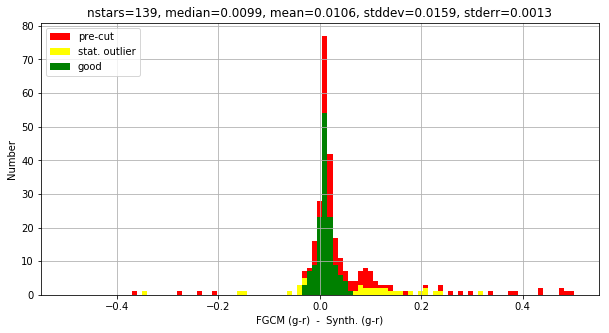

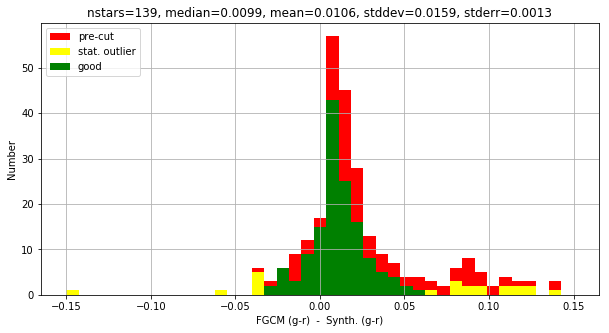

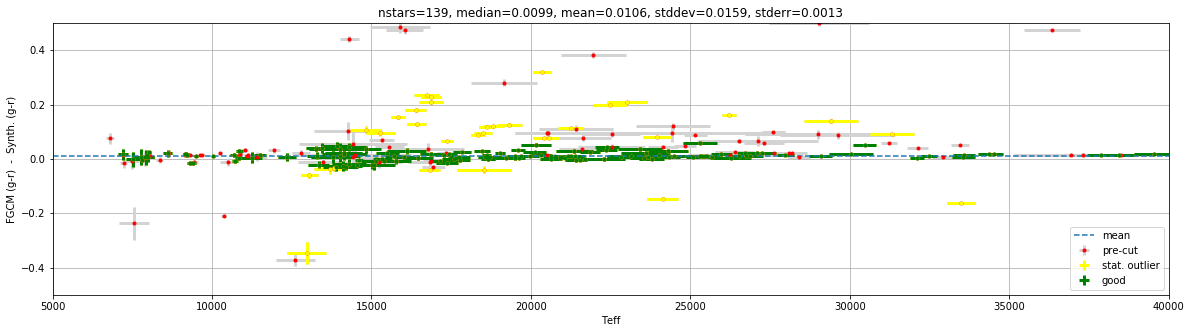

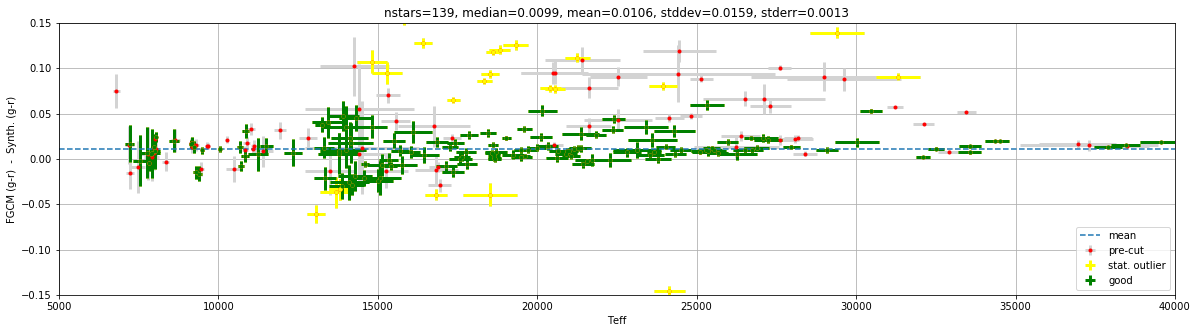

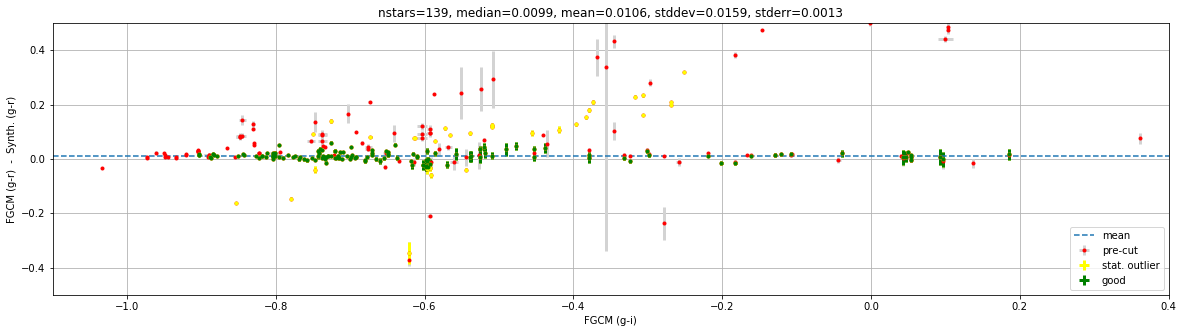

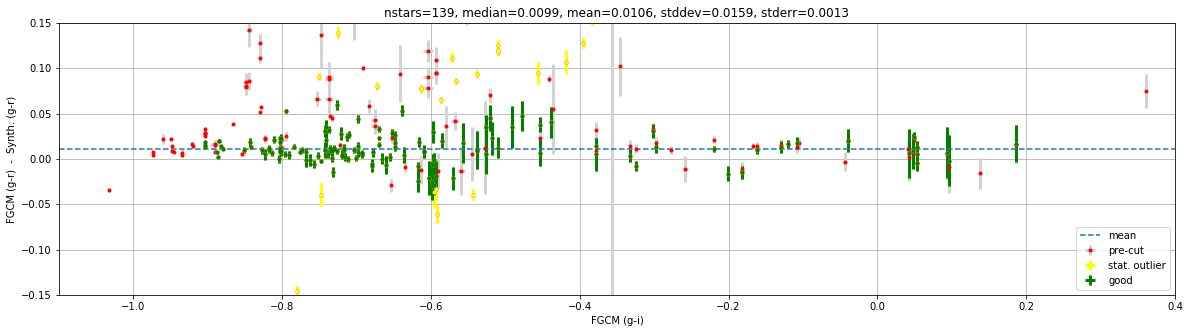

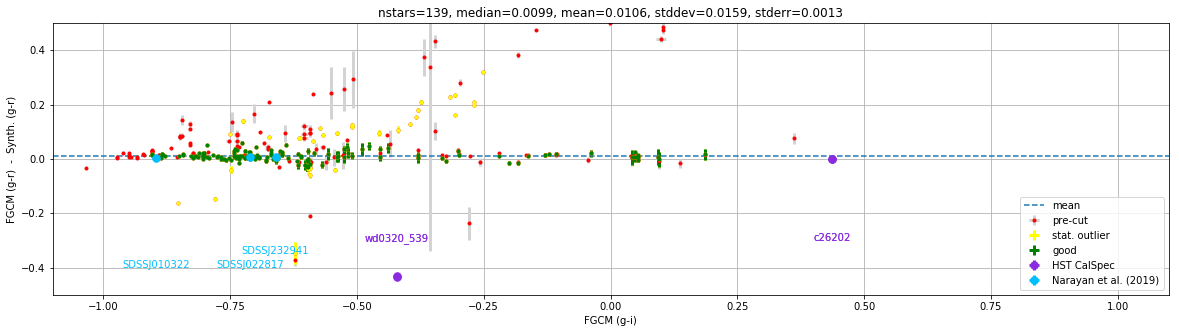

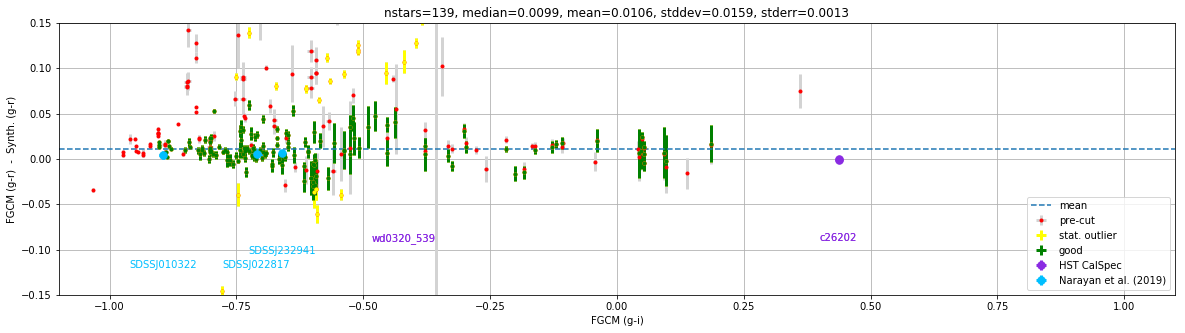

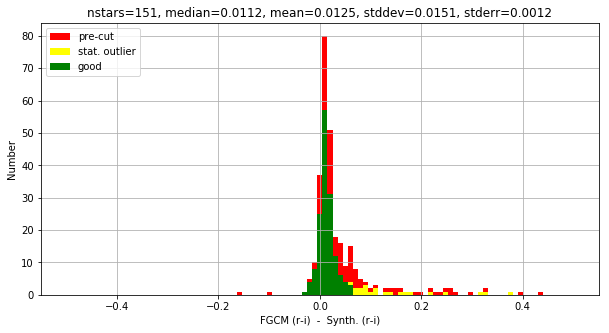

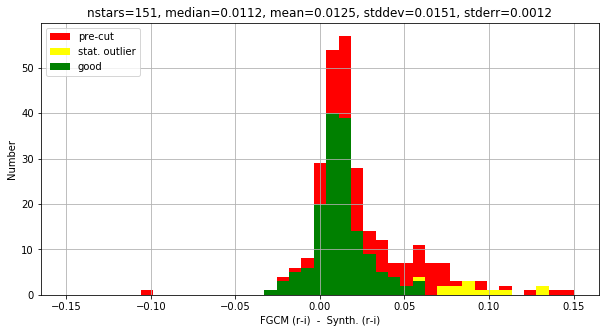

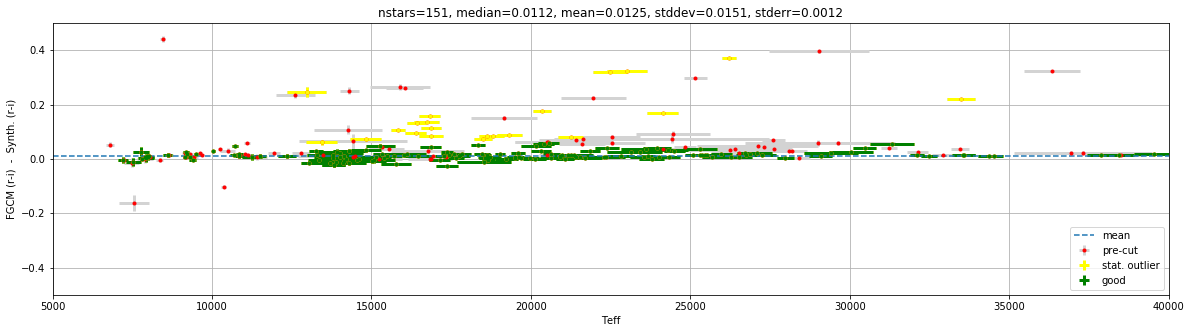

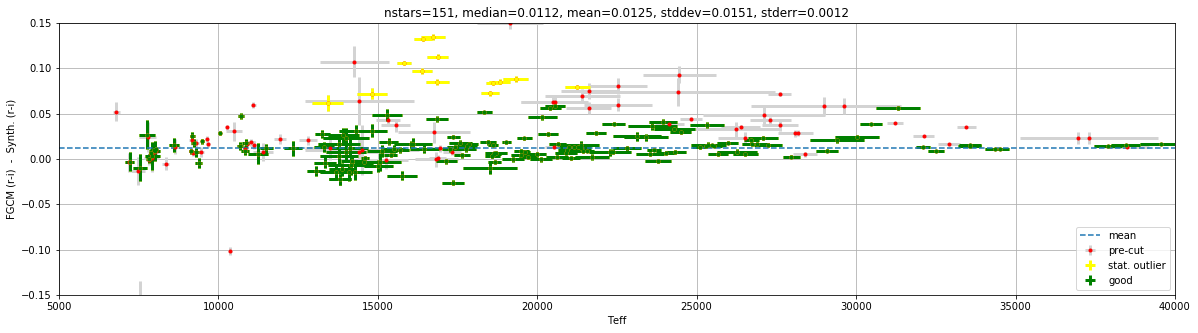

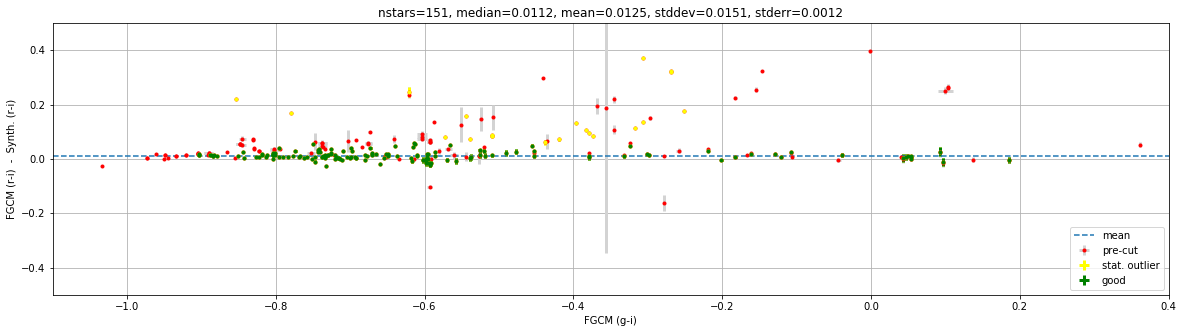

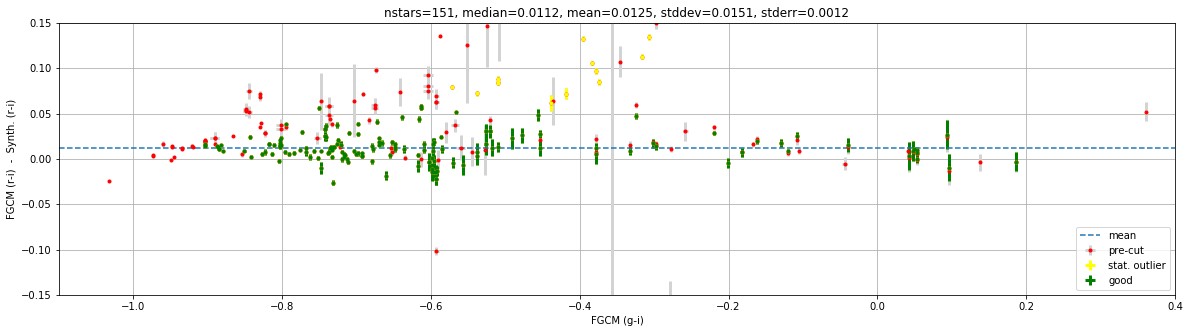

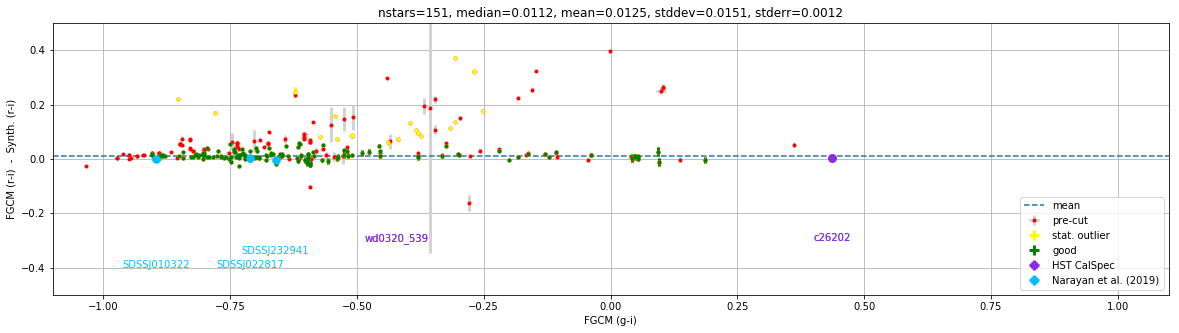

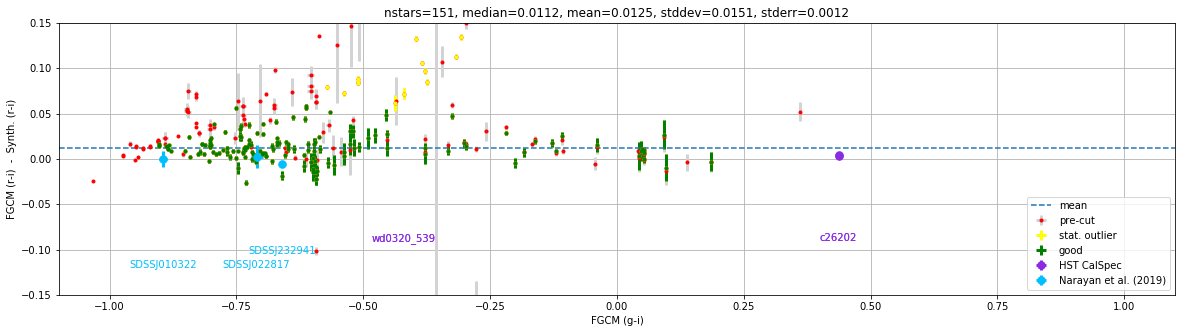

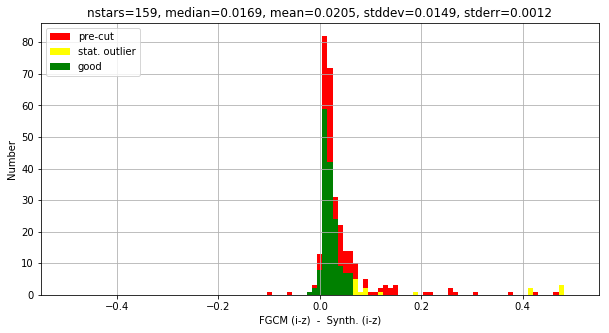

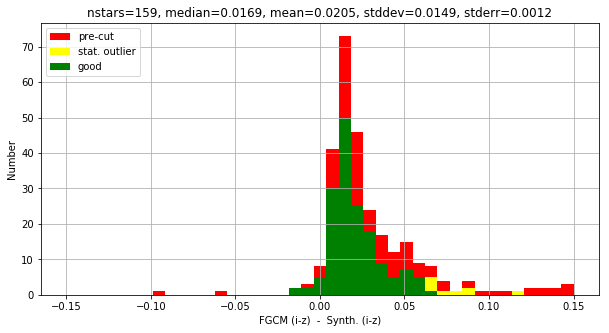

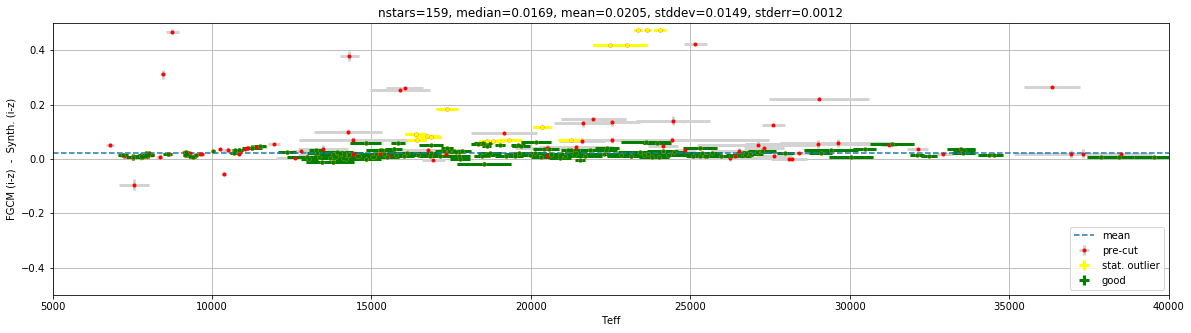

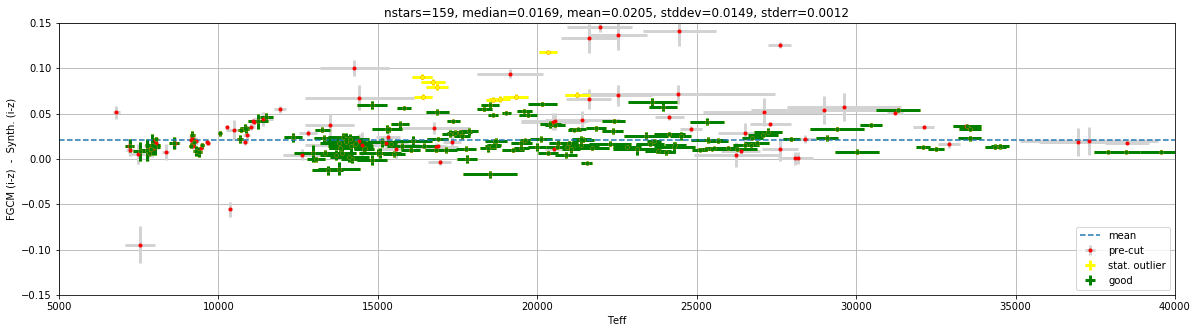

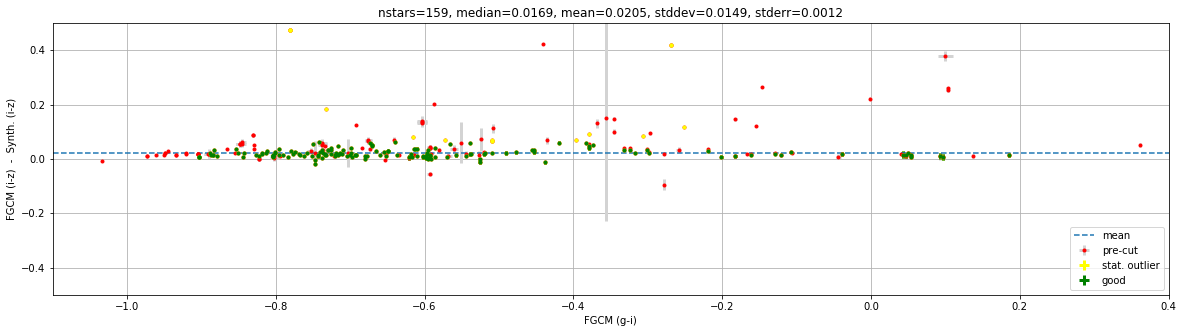

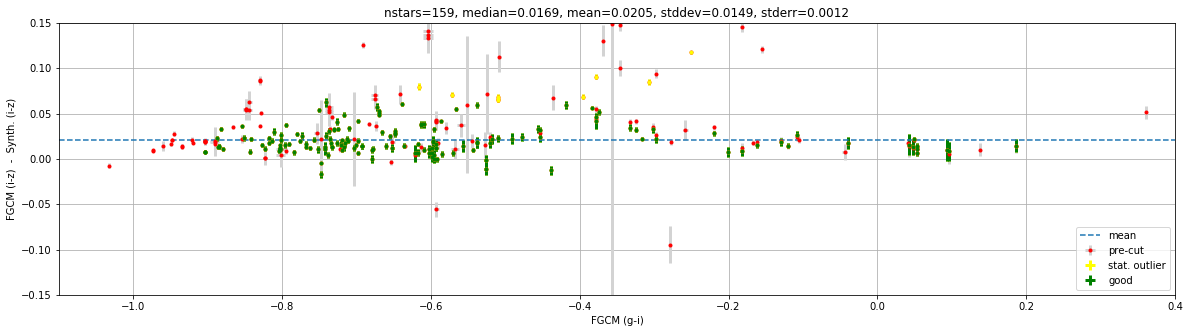

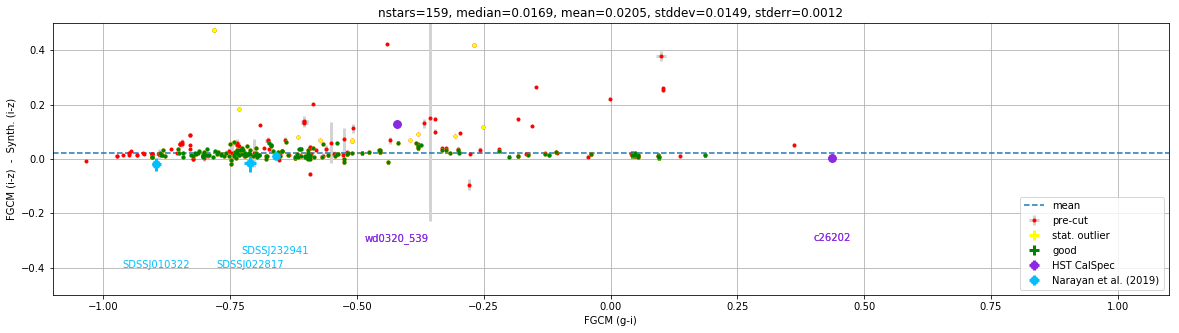

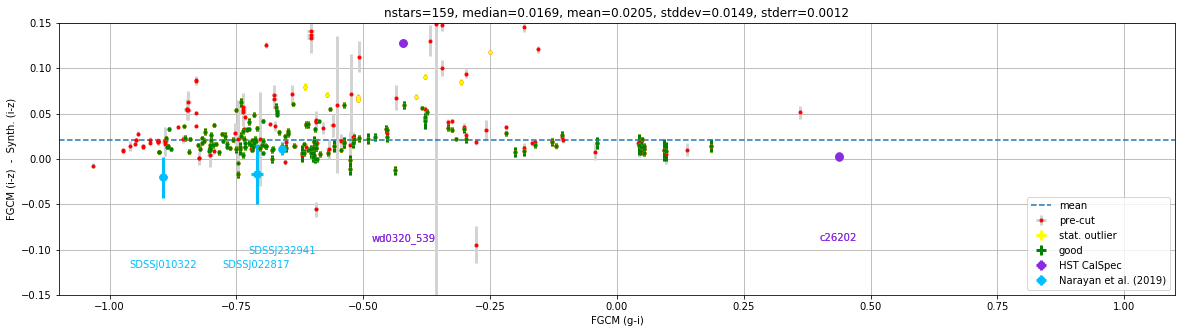

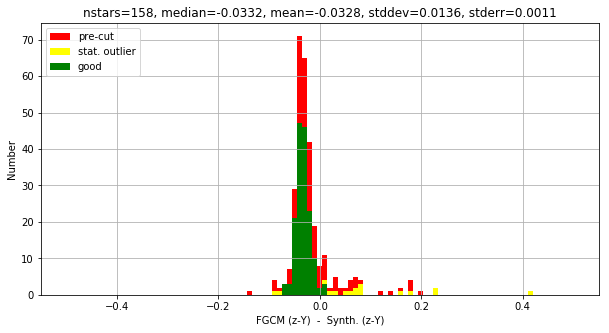

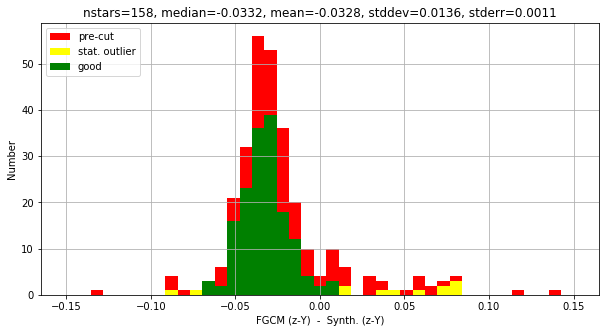

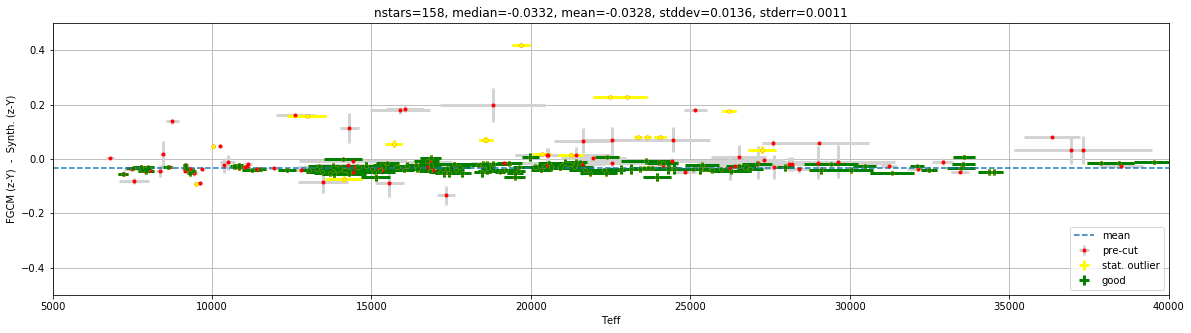

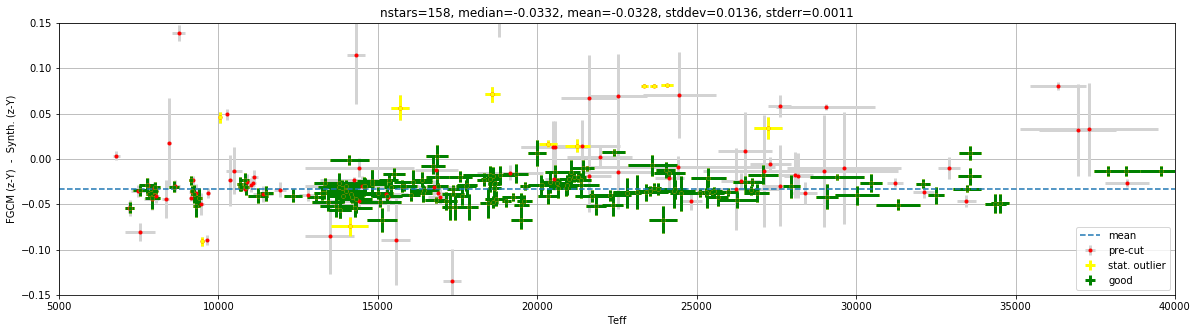

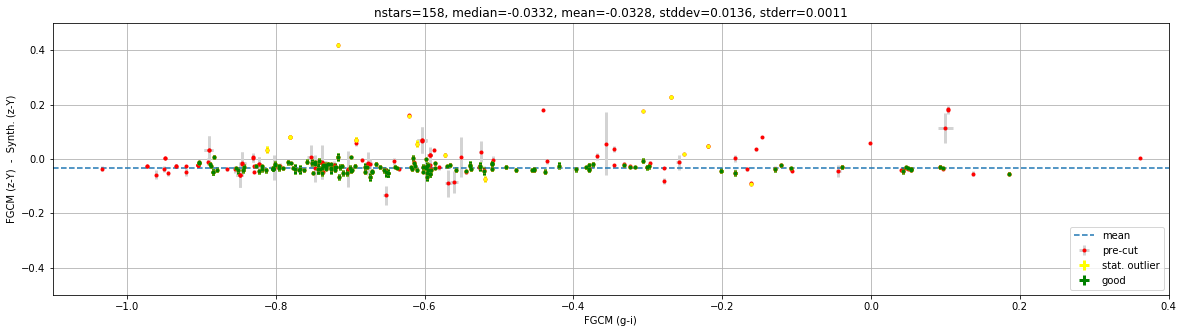

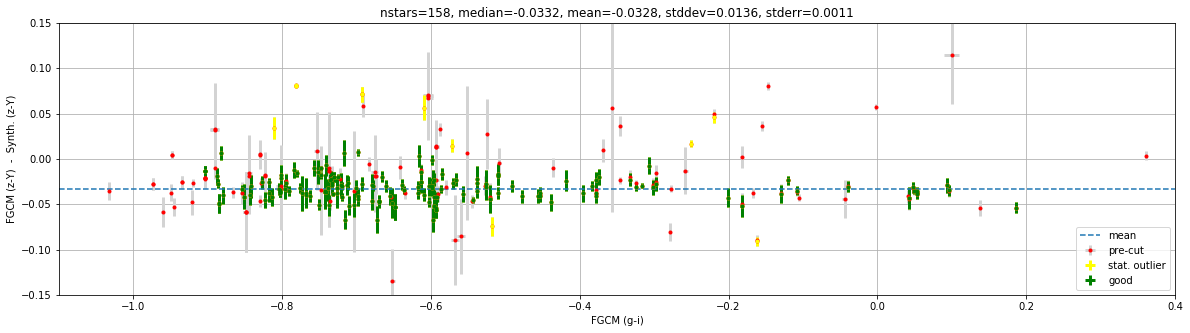

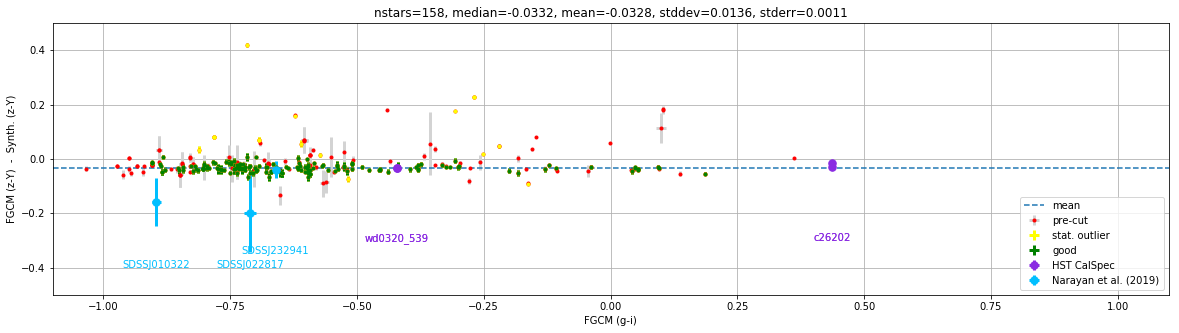

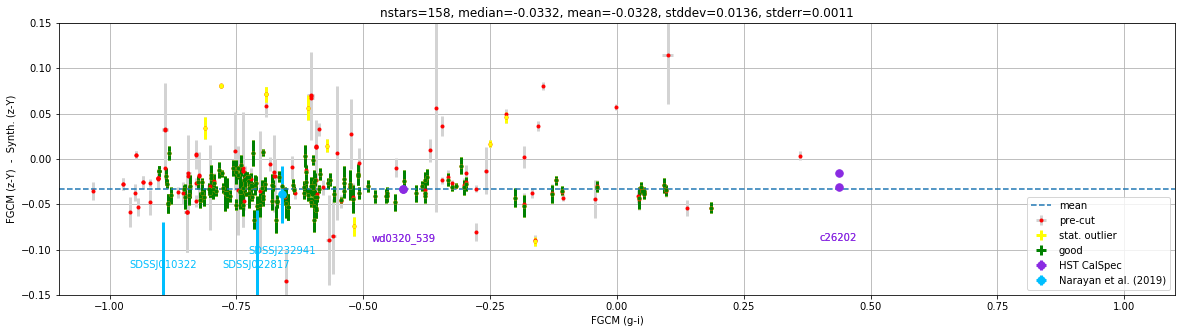

In [30]:
for i in range(len(deltaColor)):

    print( "Hi") 
    print( deltaColor[i] )
    
    column_x = deltaColor[i]
    xlabel = clabel[i]
    
    # Calculate quartiles, inter-quartile range, and IQR outlier limits
    q1,q2,q3 = data_df_clean[column_x].quantile([.25, .5, .75])
    iqr = q3 - q1
    qlo = q1 - 1.5*iqr
    qhi = q3 + 1.5*iqr
    #print q1, q2, q3, iqr, qlo, qhi
    
    # Mask out data that fall outside the IQR outlier limits...
    mask = ( (data_df_clean[column_x] >= qlo) & (data_df_clean[column_x] <= qhi) )
    data_df_cleaner = data_df_clean[mask]
    
    # Output data_df_cleaner as a CSV file...
    outputFile="""./data_df_cleaner.mag_auto.%s.csv""" % (deltaColor[i])
    data_df_cleaner.to_csv(outputFile, index=False)
    
    # Calculate AB color offset statistics for this color index...
    nrows =   data_df_cleaner[column_x].size
    xmedian = np.median(data_df_cleaner[column_x])
    xmean =   np.mean(data_df_cleaner[column_x])
    xstd =    np.std(data_df_cleaner[column_x])
    xerr =    xstd/math.sqrt(nrows-1)
    print( """%d   %.4f   %.4f   %.4f   %.4f""" % ( nrows, xmedian, xmean, xstd, xerr ))
    
    
    title="""nstars=%d, median=%.4f, mean=%.4f, stddev=%.4f, stderr=%.4f""" % \
        ( nrows, xmedian, xmean, xstd, xerr )
    print(title)
    
    # Plot the histogram of results...
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    status = histPlotCompare3(data_df, data_df_clean, data_df_cleaner, column_x, title, xlabel, -0.50, 0.50, 101)
    outputFile = """plot.%s.hist.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)
    
    # Plot zoomed-in histogram of results...
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    status = histPlotCompare3(data_df, data_df_clean, data_df_cleaner, column_x, title, xlabel, -0.15, 0.15, 41)
    outputFile = """plot.%s.hist_zoom.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)
    
    # Plot delta_colors vs. Teff...
    column_x = 'Teff'
    column_xerr = 'errT'
    xlabel = 'Teff'

    column_y = deltaColor[i]
    column_yerr = errDeltaColor[i]
    ylabel = clabel[i]
    
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    status = xyPlotCompare3(data_df, data_df_clean, data_df_cleaner, 
                       column_x, column_y, column_xerr, column_yerr, 
                       title, xlabel, ylabel, 5000., 40000., -0.50, +0.50, xmean)
    outputFile = """plot.%s.dcolor_vs_Teff.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)
    
    # Plot delta_colors vs. Teff (zoomed-in)...
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    status = xyPlotCompare3(data_df, data_df_clean, data_df_cleaner, 
                       column_x, column_y, column_xerr, column_yerr, 
                       title, xlabel, ylabel, 5000., 40000., -0.15, +0.15, xmean)
    outputFile = """plot.%s.dcolor_vs_Teff_zoom.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)


    # Plot delta_colors vs. FGCM (g-i)...
    column_x = 'gi_std'
    column_xerr = 'gi_std_err'
    xlabel = 'FGCM (g-i)'

    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    status = xyPlotCompare3(data_df, data_df_clean, data_df_cleaner, 
                       column_x, column_y, column_xerr, column_yerr, 
                       title, xlabel, ylabel, -1.1, 0.4, -0.50, +0.50, xmean)
    outputFile = """plot.%s.dcolor_vs_gi.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)
 
    # Plot delta_colors vs. FGCM (g-i) (zoomed-in)...
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    status = xyPlotCompare3(data_df, data_df_clean, data_df_cleaner, 
                       column_x, column_y, column_xerr, column_yerr, 
                       title, xlabel, ylabel, -1.1, 0.4, -0.15, +0.15, xmean)
    outputFile = """plot.%s.dcolor_vs_gi_zoom.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)
 
    # Plot delta_colors vs. FGCM (g-i), also overplotting results 
    # from HST CalSpec standards and Narayan et al. (2019) DAWDs...
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    status = xyPlotCompare3(data_df, data_df_clean, data_df_cleaner, 
                       column_x, column_y, column_xerr, column_yerr, 
                       title, xlabel, ylabel, -1.1, 1.1, -0.50, +0.50, xmean)
    status = xyPlotOverplotCalSpec(calspec_df, column_x, column_y, column_xerr, column_yerr, -0.50, +0.50)
    status = xyPlotOverplotNarayan(narayan_df, column_x, column_y, column_xerr, column_yerr, -0.50, +0.50)
    outputFile = """plot.%s.dcolor_vs_gi.calspec_narayan.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)
 
    # Plot delta_colors vs. FGCM (g-i), also overplotting results 
    # from HST CalSpec standards and Narayan et al. (2019) DAWDs (zoomed-in)...
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    status = xyPlotCompare3(data_df, data_df_clean, data_df_cleaner, 
                       column_x, column_y, column_xerr, column_yerr, 
                       title, xlabel, ylabel, -1.1, 1.1, -0.15, +0.15, xmean)
    status = xyPlotOverplotCalSpec(calspec_df, column_x, column_y, column_xerr, column_yerr, -0.15, +0.15)
    status = xyPlotOverplotNarayan(narayan_df, column_x, column_y, column_xerr, column_yerr, -0.15, +0.15)
    outputFile = """plot.%s.dcolor_vs_gi_zoom.calspec_narayan.%s.png""" %(inputFileBaseName, colorName[i])
    #plt.savefig(outputFile)
 